In [1]:
%load_ext autoreload
%autoreload 2


In [81]:
from flowField import *
from flowFieldWavy import *
import h5py
import numpy as np
import pdb
import cProfile
import time
from pseudo import *
from scipy.linalg import norm, svd
from scipy.sparse.linalg import gmres, LinearOperator
from lgmresCustom import lgmres
from scipy.optimize import newton_krylov,root,anderson
import exactRiblet as rib

import matplotlib.pyplot as plt
%matplotlib inline

docFolder = "./doc/figures/"
#%run test_flowFieldWavy.py

In [3]:
rib.testExactRibletModule(eps=0.)
rib.testExactRibletModule(eps=0.025)

(True, True)

In [3]:
vf0 = h52ff('eq1.h5')
pf0 = h52ff('eq1_pressure.h5',pres=True)
assert isinstance(vf0,flowFieldRiblet) and isinstance(pf0,flowFieldRiblet)

In [4]:
L = 4; M=6; N=20
vf=vf0.slice(L=L,M=M,N=N); pf=pf0.slice(L=L,M=M,N=N)
x0 = vf.appendField(pf)
assert isinstance(vf,flowFieldRiblet) and isinstance(pf,flowFieldRiblet) and isinstance(x0,flowFieldRiblet)

## Iterating with matrix pseudo-inverse

In [ ]:
print('initial norm:',vecnorm2(rib.residual(vf=vf, pf = pf), vf.N))
J,F = rib.makeSystem(vf=vf, pf=pf)
dx,lnorm,jrank,svals = np.linalg.lstsq(J,-F, rcond=1.0e-6)
x00 = x0.copy()
x0.view1d()[:] += dx
vf=x0.slice(nd=[0,1,2]); pf = x0.getScalar(nd=3)
print('final norm:',vecnorm2(rib.residual(vf=vf, pf = pf), vf.N))


In [6]:
vf.flowDict['eps'] = 0.025; pf.flowDict['eps'] = 0.025
vf, pf, fnormArr, flg = rib.iterate(vf=vf, pf=pf, rcond=1.0e-06, tol=1.0e-10)

Starting iterations...............
iter: 0
fnorm: 0.00867889710028
Number of variables, Rank of JacobianBC matrix: 9360 9357
len(sVals: 9360  Last 3 singular values: [  1.73870270e-05   7.20289887e-13   5.01717746e-16]
Inversion success with residual norm  2.93795012891e-15
*********************************************************
iter: 1
fnorm: 0.000188294667841
Number of variables, Rank of JacobianBC matrix: 9360 9356
len(sVals: 9360  Last 3 singular values: [  1.94054925e-05   7.20291497e-13   8.28092326e-16]
Inversion success with residual norm  1.05368805891e-16
*********************************************************
iter: 2
fnorm: 7.71099338992e-07
Number of variables, Rank of JacobianBC matrix: 9360 9356
len(sVals: 9360  Last 3 singular values: [  1.60628360e-08   7.20291487e-13   3.51509802e-16]
Inversion success with residual norm  5.87092773121e-18
*********************************************************
iter: 3
fnorm: 7.90901504828e-10
Number of variables, Rank of Jacobia

In [ ]:
vecnorm2(rib.residual(vf=vf1,pf=pf1),vf.N)

In [8]:
vf1 = vf.copy(); pf1 = pf.copy()
vf1.flowDict['eps'] = 0.05; pf1.flowDict['eps'] = 0.05
%time vf1, pf1, fnormArr, flg = rib.iterate(vf=vf1, pf=pf1, rcond=1.0e-06, tol=1.0e-10)

Starting iterations...............
iter: 0
fnorm: 0.00849358381965
Number of variables, Rank of JacobianBC matrix: 9360 9357
len(sVals: 9360  Last 3 singular values: [  4.94852536e-05   7.35939467e-13   1.87023582e-16]
Inversion success with residual norm  3.63226915373e-15
*********************************************************
iter: 1
fnorm: 0.00031609009037
Number of variables, Rank of JacobianBC matrix: 9360 9357
len(sVals: 9360  Last 3 singular values: [  3.75925437e-05   7.35940483e-13   4.80465707e-16]
Inversion success with residual norm  3.55325659774e-16
*********************************************************
iter: 2
fnorm: 5.4360259533e-06
Number of variables, Rank of JacobianBC matrix: 9360 9356
len(sVals: 9360  Last 3 singular values: [  5.92959339e-06   7.35940610e-13   8.30140484e-16]
Inversion success with residual norm  1.71308716038e-17
*********************************************************
iter: 3
fnorm: 9.50359926808e-09
Number of variables, Rank of JacobianB

In [42]:
vf0.slice(L=4,M=6,N=20).flux(), vf.flux(), vf1.flux()



(array([ -2.53239991e-17]),
 array([  1.39588317e-15]),
 array([  1.02864200e-16]))

In [ ]:
vf2 = vf1.slice(N=30); pf2 = pf1.slice(N=30)
%time vf2, pf2, fnormArr, flg = rib.iterate(vf=vf2, pf=pf2, rcond=1.0e-06, tol=1.0e-10)

Starting iterations...............
iter: 0
fnorm:

In [80]:
vfList = []; pfList = []; fnormList = []
vf = vf0.slice(L=4,M=6,N=25); pf = pf0.slice(L=4,M=6,N=25)
vf.flowDict['eps'] = 0.1; pf.flowDict['eps'] = 0.1
vf,pf,fnorm, flg = rib.iterate(vf=vf,pf=pf, rcond=1.0e-06, tol=1.0e-10)
print('eps:', vf.flowDict['eps'])
vfList.append(vf); pfList.append(pf)
for k in range(9):
    vf.flowDict['eps'] += 0.01; pf.flowDict['eps'] += 0.01
    vf,pf,fnorm, flg = rib.iterate(vf=vf,pf=pf, rcond=1.0e-06, tol=1.0e-10)
    print('eps:', vf.flowDict['eps'])
    vfList.append(vf.copy()); pfList.append(pf.copy())
    print('*******************')
print('Done..........................................')

Starting iterations...............
iter: 0
fnorm: 0.0345330121908
Number of variables, Rank of JacobianBC matrix: 11700 11697
len(sVals: 11700  Last 3 singular values: [  1.96601112e-04   1.27660498e-12   3.28529619e-16]
Inversion success with residual norm  1.79441547567e-14
*********************************************************
iter: 1
fnorm: 0.00473333420783
Number of variables, Rank of JacobianBC matrix: 11700 11697
len(sVals: 11700  Last 3 singular values: [  7.71247625e-05   1.27661250e-12   3.99648352e-16]
Inversion success with residual norm  2.41255191823e-15
*********************************************************
iter: 2
fnorm: 0.000324981877581
Number of variables, Rank of JacobianBC matrix: 11700 11696
len(sVals: 11700  Last 3 singular values: [  1.95659253e-05   1.27661287e-12   9.97418173e-16]
Inversion success with residual norm  1.52877149631e-15
*********************************************************
iter: 3
fnorm: 3.85356288263e-05
Number of variables, Rank of 

In [82]:
for k in range(len(vfList)):
    vf = vfList[k]; pf = pfList[k]
    x = vf.appendField(pf)
    flowFieldRiblet.saveh5(x)

saved field to  solutions/ribEq/ribEq1L4M6N25E1100.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1100.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1200.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1300.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1400.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1500.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1600.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1700.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1800.hdf5
saved field to  solutions/ribEq/ribEq1L4M6N25E1900.hdf5


In [6]:
vf = vfList[0]; pf = pfList[0]

In [7]:
outFile = h5py.File("testFile.hdf5","w")

In [8]:
field = outFile.create_dataset("field",data=(vf.appendField(pf)).flatten(), compression='gzip')

In [9]:
tempDict = vf.flowDict.copy()
for key in tempDict:
    field.attrs[key] = tempDict[key]

In [13]:
field.attrs['class'] = 'flowFieldRiblet'

In [14]:
outFile.close()

In [17]:
inFile = h5py.File("testFile.hdf5","r")
fieldArr = np.array(inFile['field'])
print(type(fieldArr), fieldArr.dtype, fieldArr.shape)
tempDict={}
for key in inFile['field'].attrs:
    tempDict[key] = inFile['field'].attrs[key]

<class 'numpy.ndarray'> complex128 (11700,)


In [18]:
xTemp = flowFieldRiblet(arr=fieldArr,flowDict=updateDict(tempDict,{'nd':4}))

In [19]:
vfTemp = xTemp.slice(nd=[0,1,2]); pfTemp = xTemp.getScalar(nd=3)
(vf-vfTemp).norm(),(pf-pfTemp).norm()

(0.0, 0.0)

/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


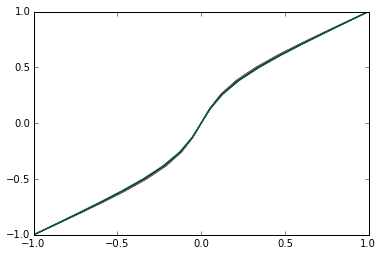

In [32]:
plt.figure()
for k in range(1,len(vfList)):
    vf = vfList[k]
    plt.plot(vf[0,vf.nx//2, vf.nz//2,0],vf.y)
plt.xlim([-1.,1.]);plt.ylim([-1.,1.])
plt.show()

0.0


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


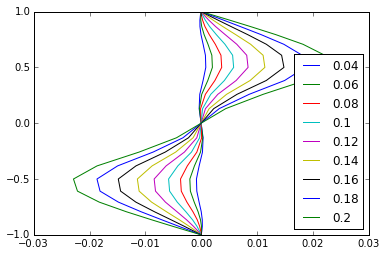

In [41]:
vf00 = vf0.slice(N=25)[0,vf0.nx//2,vf0.nz//2,0]
print(vf0.flowDict['eps'])
leg = []
plt.figure()
for k in range(1,len(vfList)):
    vf = vfList[k]
    plt.plot(vf[0,vf.nx//2, vf.nz//2,0]-vf00,vf.y)
    leg.append(str(round(2.*vf.flowDict['eps'],2)))
#plt.xlim([-1.,1.]);plt.ylim([-1.,1.])
plt.legend(leg,loc=4)
plt.show()

In [79]:
vf00 = vf0.slice(N=25)[0,vf0.nx//2,vf0.nz//2,0]
print(0,rib.shearStress(vf0))
for k in range(1,len(vfList)):
    vf = vfList[k]
    eps = vf.flowDict['eps']; b = vf.flowDict['beta']
    u = vf.slice(L=0).getScalar(); uy = u.ddy()
    shrStr = (1.+2.*eps**2 * b**2)*np.real(uy[0,uy.nx//2, uy.nz//2,0,-1])\
        -eps * b**2 * np.real(u[0,u.nx//2, u.nz//2+1,0,-1])\
        - eps**2 * b**2 * np.real(uy[0,u.nx//2, u.nz//2+2,0,-1])
    shrStr1 = rib.shearStress(vf)
    print(k, shrStr1, shrStr1-shrStr/vf.flowDict['Re'])

print('laminar:', 1./vf.flowDict['Re'])

0 0.00357314474464
1 0.00360275971608 0.0
2 0.00362144495815 0.0
3 0.0036429079361 0.0
4 0.00366724690597 0.0
5 0.00369460772162 0.0
6 0.00372513639562 0.0
7 0.0037589340008 0.0
8 0.00379602771055 0.0
9 0.00383636692471 0.0
laminar: 0.0025


In [48]:

vf00.__class__

flowFieldWavy.flowFieldRiblet

In [ ]:
def vecnorm2(vec,N):
    m = vec.size//N
    w = clencurt(N).reshape((1,N))
    W = np.tile(w,(1,m))
    tempVec = vec.reshape(vec.size,1)
    tempVecConj = tempVec.conj().T
    
    vecNorm = np.sqrt(np.abs( np.dot( tempVecConj*W, tempVec ) ))
    return vecNorm[0,0]/2.

#flowDict = tempDict
finDifEps =1.0e-7
def residual(xArr,**kwargs):
    xTemp = weighted2ff(flowDict=x0.flowDict, arr=xArr)
    vf = xTemp.slice(L=xTemp.nx//2+2,M=xTemp.nx//2+2, nd=[0,1,2])
    pf = xTemp.slice(L=xTemp.nx//2+2,M=xTemp.nx//2+2, nd=[3])
    resid = (vf.residuals(pField=pf,**kwargs)).appendField(vf.div())
    #return resid.slice(L=xF.nx//2,M=xF.nz//2)
    return resid.slice(L=xTemp.nx//2,M=xTemp.nz//2).weighted() # .slice(L=xF.nx//2)

def ffResidual(xTemp,**kwargs):
    vf = xTemp.slice(L=xTemp.nx//2+2,M=xTemp.nx//2+2, N=xTemp.N+2, nd=[0,1,2])
    pf = xTemp.slice(L=xTemp.nx//2+2,M=xTemp.nx//2+2, N=xTemp.N+2, nd=[3])
    resid = (vf.residuals(pField=pf,**kwargs)).appendField(vf.div())
    #return resid.slice(L=xF.nx//2,M=xF.nz//2)
    return resid.slice(L=xTemp.nx//2,M=xTemp.nz//2, N=xTemp.N) # .slice(L=xF.nx//2)

## Resolution for low order inversion

### Energy in state-vector modes

In [ ]:
x0 = vf0.appendField(pf0)
xArr = np.zeros((x0.nx,x0.nz,4,x0.N),dtype=np.complex)
for lp in range(vf0.nx):
    for mp in range(vf0.nz):
        for nd in range(4):
            xArr[lp,mp,nd] = chebcoeffs( x0[0,lp,mp,nd]  )
    

In [ ]:
# chebMode energy content
chebEnergy = np.sum(np.sum(np.sum(np.abs(xArr),axis=0),axis=0),axis=0)
chebEnergyTot = np.sum(chebEnergy)
chebEnergyV = np.sum(np.sum(np.sum(np.abs(xArr[:,:,:3]),axis=0),axis=0),axis=0)
chebEnergyVTot = np.sum(chebEnergyV)
plt.plot(chebEnergy/chebEnergyTot,'k')
plt.xlabel("Chebyshev polynomial"); plt.ylabel("Energy fraction")
plt.yscale("log")
plt.savefig(docFolder+'chebEnergy.pdf',format='pdf')
plt.show()
plt.plot(chebEnergyV/chebEnergyVTot,'b--')
plt.xlabel("Chebyshev polynomial"); plt.ylabel("Energy fraction")
plt.yscale("log")
plt.savefig(docFolder+'chebEnergyV.pdf',format='pdf')
plt.show()

In [ ]:
xEnergy = np.sum(np.sum(np.sum(np.abs(xArr),axis=1),axis=1),axis=1)
xEnergyTot = np.sum(xEnergy)
zEnergy = np.sum(np.sum(np.sum(np.abs(xArr),axis=0),axis=1),axis=1)
zEnergyTot = np.sum(zEnergy)
plt.figure()
plt.plot(2*np.arange(24)+1,xEnergy[23:]/xEnergyTot,'k--')
plt.plot(2*np.arange(24)+1,zEnergy[23:]/zEnergyTot,'k')
plt.plot(chebEnergy/chebEnergyTot,'k-.')
plt.xlabel("No. of modes"); plt.ylabel("Energy fraction")
plt.yscale("log")
plt.legend(["x","z","y"])
plt.savefig(docFolder+'modeEnergy.pdf',format='pdf')
plt.ylim([1.0e-06,2.0])
plt.savefig(docFolder+'modeEnergyZoom.pdf',format='pdf')
plt.show()


In [ ]:
for lTrun in range(3,6):
    for mTrun in range(5,8):
        for NTrun in range(15,22,3):
            print(lTrun,mTrun,NTrun,
                  1.-np.sum(np.abs(
                        xArr[23-lTrun:23+lTrun+1,23-mTrun:23+mTrun+1,:,:NTrun].flatten()
                    ))/xEnergyTot)

### Residual norm

In [ ]:
resNormArr = np.zeros((7,7,7))
for lp in range(7):
    for mp in range(7):
        for Np in range(7):
            N = 3*Np+10
            resNormArr[lp,mp,Np] = ffResidual(x0.slice(L=2*lp,M=2*mp,N=N)).norm()


In [ ]:
from matplotlib.colors import LogNorm
plt.contourf(10+3*np.arange(7),4*np.arange(7)+1,resNormArr[1,:,:],levels=10.**np.arange(-5,-1,0.25), norm=LogNorm(),cmap=plt.cm.bone)
plt.xlabel("N"); plt.ylabel("2M+1")
plt.colorbar()
plt.savefig(docFolder+'resNormL2.pdf',format='pdf')
plt.show()

In [ ]:
ffResidual(x0).norm()

In [ ]:
print(norm(residual(x0.weighted())))
x0.flowDict['eps'] = 0.01
norm(residual(x0.weighted()))

In [ ]:
# Preconditioner based on linear operator
start = time.time()
LmatInv = rib.linrInv(x0.flowDict)
print(time.time()-start)
def precondMatvec(xArr):
    nx = LmatInv.shape[0]
    xTemp = xArr.reshape((nx,xArr.size//nx))
    dotProd = np.zeros(xTemp.shape, dtype=np.complex)
    for lp in range(nx):
        dotProd[lp] = np.dot(LmatInv[lp], xTemp[lp])
    
    return dotProd.flatten()

precond = LinearOperator(matvec=precondMatvec, shape= (x0.size,x0.size),dtype=np.complex)
    
    

In [ ]:
start = time.time()
sol = newton_krylov(residual, x00.weighted(), rdiff=1.0e-04,iter=5,   method='gmres',  f_tol=1.0e-9,f_rtol=1.0e-4,verbose=True,
                    inner_maxiter=5, inner_M= precond,inner_tol=1.0e-03 , inner_restrt = x0.size//100)
time.time()-start


In [ ]:
x00 = x0.copy()
x0 = weighted2ff(arr=sol, flowDict=x0.flowDict)

In [ ]:
xNew = weighted2ff(flowDict=x0.flowDict,arr=sol)

In [ ]:
norm(residual(sol))

In [ ]:
norm(residual(x0.weighted())), x0.flowDict

In [ ]:
start = time.time()
dx, = newton_krylov(residual, x0.weighted(), iter=5,   method='gmres',  f_tol=1.0e-9,f_rtol=1.0e-4,verbose=True,
                    inner_maxiter=5, inner_M= precond,inner_tol=1.0e-03 , inner_restrt = x0.size//10)
time.time()-start


## Custom Newton-Krylov

In [ ]:
epsil = 1.0e-07
def jacobian(dx,x):
    rp1 = residual(x + epsil*dx)
    rm1 = residual(x - epsil*dx)
    
    matvec = (rp1 - rm1)/2./epsil
    return matvec

jcbn = lambda dx: jacobian(dx,x0.weighted())

JOp = LinearOperator(matvec = jcbn, shape = (x0.size,x0.size),dtype=np.complex)
JPrFun = lambda xArr: JOp.matvec(precond.matvec(xArr))
JPrOp = LinearOperator(matvec=JPrFun, shape = (x0.size,x0.size),dtype=np.complex)    

In [ ]:
start = time.time()
dx,info = gmres(JPrOp, -residual(x0.weighted()), x0=x0.weighted(), maxiter=5, 
                tol=1.0e-09,restart = x0.size//10)
time.time()-start


In [ ]:
x00 = x0.copy()

In [ ]:
x0.view1d()[:] += precond.matvec(dx)
norm(residual(x00.weighted())), norm(residual(x0.weighted()))

In [ ]:
info, norm( JOp.matvec(dx)+residual(x00.weighted())  )

## Matrix-based solution

In [ ]:
import exactRiblet as rib

Lmat = rib.linr(vf0.flowDict.copy())

In [ ]:
vf = vf0.slice(L=4,M=8); pf = pf0.slice(L=4,M=8)
xff = vf.appendField(pf)

linTerm = np.dot(Lmat,xff.flatten())
linTermClass = -1./vf.flowDict['Re']*vf.laplacian() + pf.grad()
linTermClass = linTermClass.appendField(vf.div())

In [ ]:
np.linalg.norm(linTerm-linTermClass.flatten())

In [ ]:
rib.testExactRibletModule()

In [ ]:
start = time.time()
LmatInv = np.linalg.pinv(Lmat)
time.time()-start